In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import seaborn as sns
import os

Employing a CNN model with frequency-transformed EEG spectrograms as input and idealized expert opinions on brain activity type as labels to classify EEG brain activity type. Input is concatenation of original spectrograms part of the Kaggle HMS - Harmful Brain Activity Classification dataset, and spectrograms generated from EEG nodes signals. 

Transformation of EEG to spectrograms is referenced from [Chris Deotte How To Make Spectrogram from EEG](https://www.kaggle.com/code/cdeotte/how-to-make-spectrogram-from-eeg)

Concatenation of Kaggle spectrograms and EEG spectrogams that are outputed as 8 channel image of size 128x256x8 is referenced from [Chris Deotte EfficientNetB0 Starter](https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43#Train-DataLoader)


In [117]:
DROP_LOW_PERC_CLASSES = True

In [118]:
all_k_spectrograms = dict(np.load('filtered_specs.npy', allow_pickle=True))

In [119]:
#all_eeg_spectrograms = np.load('/kaggle/input/brain-eeg-spectrograms/eeg_specs.npy',allow_pickle=True).item()
USE_ONLY_EEG_SPECS = False
if USE_ONLY_EEG_SPECS:
    all_eeg_spectrograms = dict(np.load('filtered_eeg_specs.npy', allow_pickle=True))
else:
    all_eeg_spectrograms = dict(np.load('mutual_subset_eeg_specs.npy', allow_pickle=True))

In [120]:
print(set(list(all_eeg_spectrograms.keys())) == set(list(all_k_spectrograms.keys())))
len(all_eeg_spectrograms.keys())
len(all_k_spectrograms.keys())
train_ids = list(all_eeg_spectrograms.keys())

True


In [121]:
#cited from: https://www.kaggle.com/code/cdeotte/how-to-make-spectrogram-from-eeg
import librosa

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

USE_WAVELET = None #or "db8" or anything below

#The wavelet functions we can use:
#['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'shan', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']

def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

Converting Test EEG to Spectrograms...



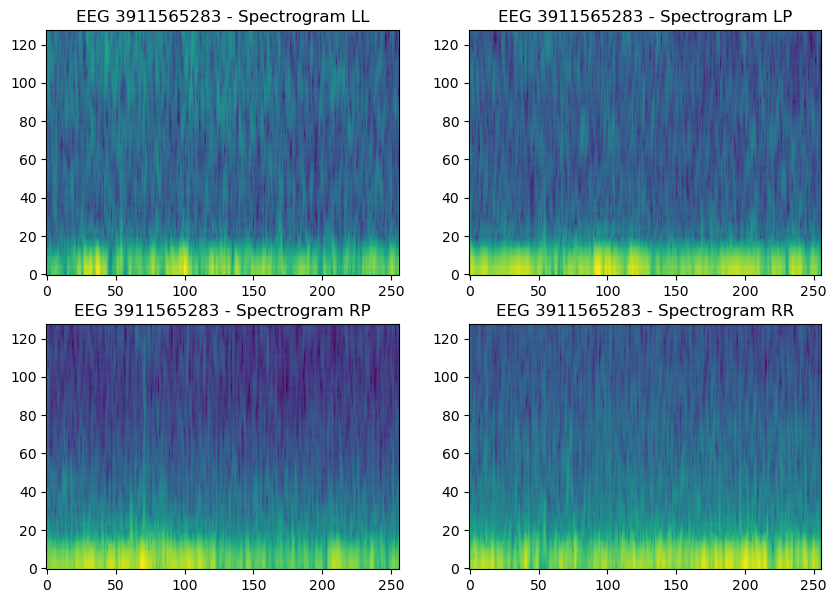

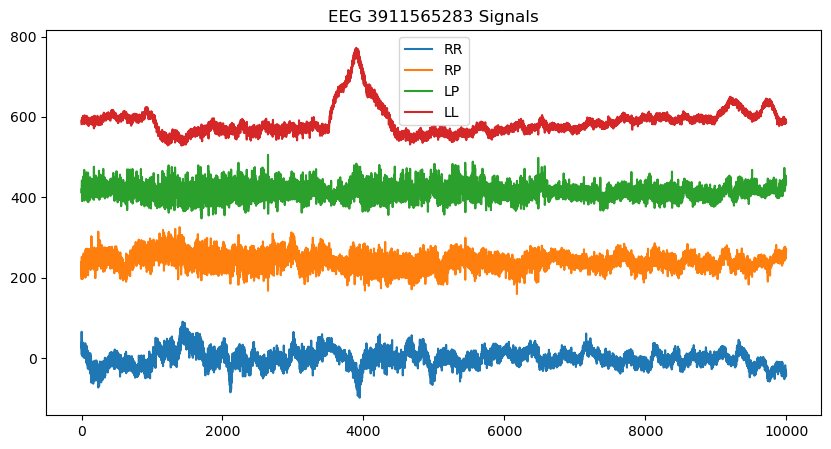


#########################



In [122]:
test_df = pd.read_csv('test.csv')
TEST_IDS = test_df.eeg_id.unique()
TEST_EEG_PATH = 'test_eegs/'
test_eeg_spectrograms = {}
DISPLAY=1

print('Converting Test EEG to Spectrograms...'); print()
for i,eeg_id in enumerate(TEST_IDS):
        
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{TEST_EEG_PATH}{eeg_id}.parquet', i<DISPLAY)
    test_eeg_spectrograms[eeg_id] = img


In [123]:
print("Number of generated EEG spectrograms:", len(all_eeg_spectrograms))
print("Shape of one generated spectrogram file:", all_eeg_spectrograms[train_ids[1]].shape)


print("\n\nNumber of Kaggle EEG spectrograms:", len(all_k_spectrograms))
print("Shape of one kaggle spectrogram file:", all_k_spectrograms[train_ids[1]].shape)

test_eeg_spectrograms_ids = list(test_eeg_spectrograms.keys())
print("\n\nShape of test EEG spectrogram file:", len(test_eeg_spectrograms))

train_df = pd.read_csv('filtered_train.csv')
train_df = train_df[train_df['eeg_id'].isin(train_ids)]

print("Number of final ids for training:", len(train_ids))

print("Len of filtered train df (after subsetting to only ids in kaggle specs:)", train_df.shape[0]) #has multiple rows for each eeg_id

Number of generated EEG spectrograms: 416
Shape of one generated spectrogram file: (128, 256, 4)


Number of Kaggle EEG spectrograms: 416
Shape of one kaggle spectrogram file: (327, 400)


Shape of test EEG spectrogram file: 1
Number of final ids for training: 416
Len of filtered train df (after subsetting to only ids in kaggle specs:) 1834


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True
{'LPD', 'Seizure', 'GPD', 'Other'}


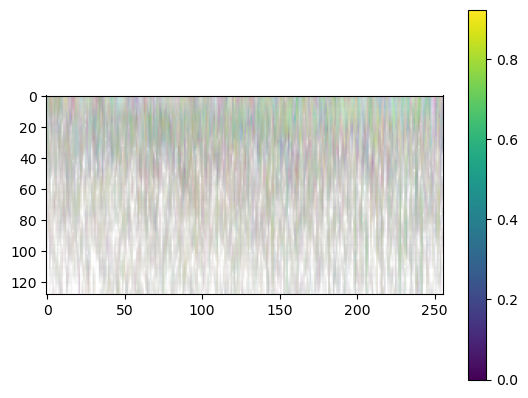

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


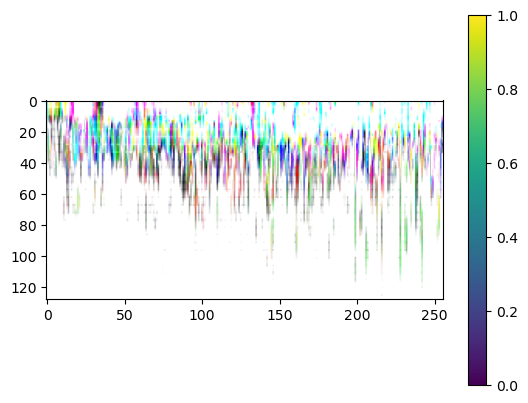

In [124]:
#quick sanity checks
print(set(train_ids) == set(train_df.eeg_id.tolist()))

print(set(train_df.expert_consensus.tolist()))



def normalize_each(X):
    min_each_channel = X.min(axis=(0, 1))
    max_each_channel = X.max(axis=(0, 1))
    norm_X = (X - min_each_channel) / (max_each_channel - min_each_channel)
    return norm_X

def standardize(X):
    mean_p_c = np.mean(X,axis=(0, 1))
    sd_p_c = np.std(X,axis=(0, 1))
    stand_X = (X - mean_p_c) / sd_p_c
    return stand_X

x = all_eeg_spectrograms[train_ids[1]]
x1 = normalize_each(x)
#x2 = log_transform(x)
x2 = standardize(x)

plt.imshow(x)
plt.colorbar()
plt.show()

plt.imshow(x2)
plt.colorbar()
plt.show()

In [125]:
# data cleaning
def check_overlap(row1, row2):
    if row1['eeg_id']==row2['eeg_id'] and row1['eeg_label_offset_seconds'] < row2['eeg_label_offset_seconds']:
        return True
    return False

In [126]:
#remove overlapping rows belonging to same eeg_id

REMOVE_OVERLAPS = True
if REMOVE_OVERLAPS:
    train_df = train_df.drop_duplicates(subset='eeg_id', keep='first')

In [127]:
print('Train shape:', train_df.shape)
targets = train_df.expert_consensus.tolist()

Train shape: (416, 16)


In [128]:
#cited from https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43#Train-DataLoader

#concat kaggle spectrograms and eeg_spectrograms
train_X = np.zeros((len(train_ids),128,256,8),dtype='float32')
trainX_dict = {}
for i, eeg_id in enumerate(train_ids):
    k_spec = all_k_spectrograms[eeg_id]
    #take first 300 rows from spectrogram
    #reshape kaggle spectrograms to have same shape as eeg spectrograms
    #orig shape of kaggle specs: (n, 400)
    new_k_spec =  np.zeros((128,256,4),dtype='float32')
    for k in range(4):
        img = k_spec[0:300,k*100:(k+1)*100].T
        
        # LOG TRANSFORM SPECTROGRAM
        img = np.clip(img,np.exp(-4),np.exp(8))
        img = np.log(img)
        
        # STANDARDIZE PER IMAGE
        ep = 1e-6
        m = np.nanmean(img.flatten())
        s = np.nanstd(img.flatten())
        img = (img-m)/(s+ep)
        img = np.nan_to_num(img, nan=0.0)
        
        # CROP TO 256 TIME STEPS
        new_k_spec[14:-14,:,k] = img[:,22:-22] / 2.0
    eeg_spec = all_eeg_spectrograms[eeg_id]

    def standardize(X):
        mean_p_c = np.mean(X,axis=(0, 1))
        sd_p_c = np.std(X,axis=(0, 1))
        stand_X = (X - mean_p_c) / sd_p_c
        return stand_X

    eeg_spec = standardize(eeg_spec)
    
    x = np.concatenate((new_k_spec, eeg_spec), axis=2)
    train_X[i] = x
    trainX_dict[eeg_id] = x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape of train_X: (416, 128, 256, 8)
shape of train_y: (416,)
num train ids: 416


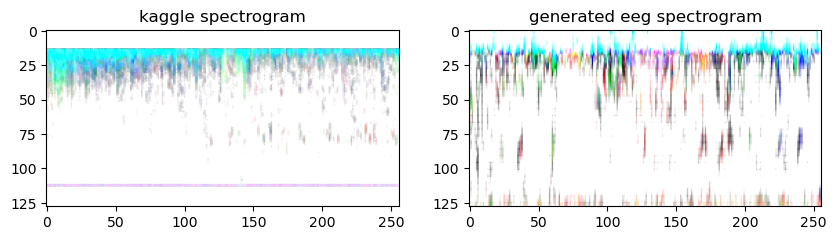

(128, 256, 8)


In [129]:
print("shape of train_X:", train_X.shape)

train_y = train_df['expert_consensus'].values
print("shape of train_y:", train_y.shape)

print("num train ids:", len(train_ids))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  
axs[0].imshow(train_X[4][:,:,:4])
axs[0].set_title('kaggle spectrogram')

axs[1].imshow(train_X[4][:,:,4:])
axs[1].set_title('generated eeg spectrogram')
plt.show()

print(train_X[412].shape)

In [130]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import os 
import torch
from sklearn.model_selection import KFold, GroupKFold

class SpectrogramData(Dataset):

    def __init__(self,
                 ids,
                 targets,
                 cuda=True):
        
        self.cuda = cuda
        self.ids = ids
        if DROP_LOW_PERC_CLASSES:
            self.targets_dict = {'Other':0,'Seizure':1,'GPD':2,'LPD':3}
        else:
            self.targets_dict = {'Other':0,'Seizure':1,'GPD':2,'GRDA':3,'LRDA':4, 'LPD':5}
        self.targets = [self.targets_dict[target] for target in targets]
        
    def __len__(self):
        return len(self.ids)
    

    def __getitem__(self, idx):
        sample = trainX_dict[self.ids[idx]]
        target = self.targets[idx]
        #sample = self.standardize(sample)

        sample = sample.transpose((2, 0, 1))
        return (sample, target)
        
    def standardize(self, X):
        mean_p_c = np.mean(X,axis=(0, 1))
        sd_p_c = np.std(X,axis=(0, 1))
        stand_X = (X - mean_p_c) / sd_p_c
        return stand_X
            

    def normalize(self, X):
        min_each_channel = X.min(axis=(0, 1))
        max_each_channel = X.max(axis=(0, 1))
        norm_X = (X - min_each_channel) / (max_each_channel - min_each_channel)
        return norm_X

CUDA = torch.cuda.is_available()

In [131]:
#@Ziqi Chen: referenced from homework 3 lab 2 

import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class CNN(nn.Module):
    def __init__(self):
        if DROP_LOW_PERC_CLASSES:
            self.output_dim = 4
        else:
            self.output_dim = 6 
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=64, kernel_size=8)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flat_size = 256*26*58
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features = self.flat_size, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=32)
        self.lin_output = nn.Linear(in_features=32, out_features=self.output_dim)

        self.leaky = True
        self.leaky_slope = 0.02

        self.initialize_weights = True
        if self.initialize_weights:
            gain = init.calculate_gain('leaky_relu', self.leaky_slope)
            init.xavier_uniform_(self.conv1.weight, gain=gain)
            init.constant_(self.conv1.bias, 0)
            init.xavier_uniform_(self.conv2.weight, gain=gain)
            init.constant_(self.conv2.bias, 0)
            init.xavier_uniform_(self.conv3.weight, gain=gain)
            init.constant_(self.conv3.bias, 0)
            init.xavier_uniform_(self.fc1.weight, gain=gain)
            init.constant_(self.fc1.bias, 0)
            init.xavier_uniform_(self.lin_output.weight, gain=gain)
            init.constant_(self.lin_output.bias, 0)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x), negative_slope=self.leaky_slope))
        x = self.pool(F.leaky_relu(self.conv2(x), negative_slope=self.leaky_slope))
        x = F.leaky_relu(self.conv3(x), negative_slope=self.leaky_slope)
        #reshape
        x = x.view(-1, self.flat_size)
        x = F.leaky_relu(self.fc1(x), negative_slope=self.leaky_slope)
        x = F.leaky_relu(self.fc2(x), negative_slope=self.leaky_slope)
        x = self.lin_output(x)
        return x


In [132]:
from torch import optim

EPOCH_RANGE = 6
model = CNN()
LR = .0001
BATCH_SIZE = 4

def train_CNN_specs(lr, EPOCH_RANGE):
    print('\n')
    print('#'*40)
    print(f'### learning rate = {lr}, num epochs = {EPOCH_RANGE}')
    optimizer = optim.Adam(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()

    train_accuracies = []
    val_accuracies=[]

    val_preds = []
    val_true = []

    VALIDATE = True
    gkf = GroupKFold(n_splits=EPOCH_RANGE)
    for epoch, (train_index, val_index) in enumerate(gkf.split(trainX_dict, train_y, train_ids)):
        
        gkf_train_ids = [train_ids[i] for i in train_index]
        gkf_val_ids = [train_ids[i] for i in val_index]
        gkf_train_y = [train_y[i] for i in train_index]
        gkf_val_y = [train_y[i] for i in val_index]

        train_dataset = SpectrogramData(ids = gkf_train_ids, targets = gkf_train_y, cuda=True)
        val_dataset = SpectrogramData(ids = gkf_val_ids, targets = gkf_val_y, cuda=True)

        # print("Val IDs:")
        # print(gkf_val_ids)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=0, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=0, pin_memory=True)
        print('#'*25)
        print(f'### Epoch {epoch+1}')
        total_loss = 0
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        val_acc = 0
        total_val=0

        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            total_train+=inputs.size(0)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, train_out = torch.max(outputs.data, 1)
            correct_train += (train_out==labels).sum().item()
        train_acc = correct_train / total_train
        train_accuracies.append(train_acc)
        epoch_loss = running_loss / total_train

        if VALIDATE:
            model.eval()
            with torch.no_grad():
                for i, data in enumerate(val_loader, 0):
                    val_input, val_label = data
                    total_val += val_input.size(0)
                    raw_logits = model(val_input)
                    logits = F.softmax(raw_logits,dim=-1)
                    val_out = torch.argmax(logits, 1)
                    val_acc += (val_out == val_label).sum().item()
                    # print("True validation labels:", val_label)
                    # print("Predictions:",val_out)
                    val_true.extend(val_label.tolist())
                    val_preds.extend(val_out.tolist())
            val_acc = val_acc/total_val
            val_accuracies.append(val_acc)
            print(f"Epoch {epoch+1} Loss = {round(epoch_loss, 4)}, train accuracy = {round(train_acc, 4)}, validation accuracy = {round(val_acc,4)}")
        else:
            print(f"Epoch {epoch+1} Loss = {round(epoch_loss, 4)}, train accuracy = {round(train_acc, 4)}")
    return train_accuracies, val_accuracies, val_true, val_preds



########################################
### learning rate = 0.0001, num epochs = 6
#########################
### Epoch 1
Epoch 1 Loss = 0.3087, train accuracy = 0.5954, validation accuracy = 0.7286
#########################
### Epoch 2
Epoch 2 Loss = 0.0938, train accuracy = 0.8728, validation accuracy = 0.9714
#########################
### Epoch 3
Epoch 3 Loss = 0.0417, train accuracy = 0.9481, validation accuracy = 0.9565
#########################
### Epoch 4
Epoch 4 Loss = 0.0355, train accuracy = 0.9568, validation accuracy = 0.8841
#########################
### Epoch 5
Epoch 5 Loss = 0.0313, train accuracy = 0.9481, validation accuracy = 0.942
#########################
### Epoch 6
Epoch 6 Loss = 0.0214, train accuracy = 0.9683, validation accuracy = 0.9855


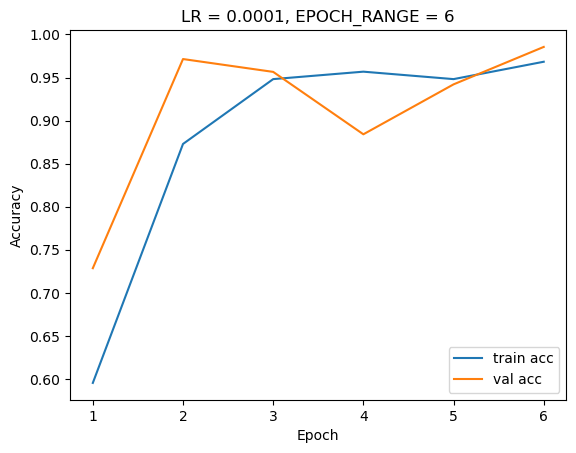

[[57  0  0  9]
 [ 2 77  0  0]
 [ 0  0 20  1]
 [ 1  0  0 41]]


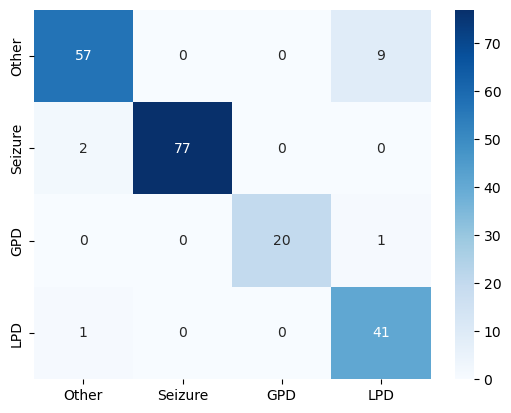



########################################
### learning rate = 0.0001, num epochs = 10
#########################
### Epoch 1
Epoch 1 Loss = 0.0256, train accuracy = 0.9572, validation accuracy = 0.9762
#########################
### Epoch 2
Epoch 2 Loss = 0.0063, train accuracy = 0.9866, validation accuracy = 1.0
#########################
### Epoch 3
Epoch 3 Loss = 0.0059, train accuracy = 0.9893, validation accuracy = 0.9524
#########################
### Epoch 4
Epoch 4 Loss = 0.0004, train accuracy = 1.0, validation accuracy = 1.0
#########################
### Epoch 5
Epoch 5 Loss = 0.0001, train accuracy = 1.0, validation accuracy = 1.0
#########################
### Epoch 6
Epoch 6 Loss = 0.0, train accuracy = 1.0, validation accuracy = 1.0
#########################
### Epoch 7
Epoch 7 Loss = 0.0, train accuracy = 1.0, validation accuracy = 1.0
#########################
### Epoch 8
Epoch 8 Loss = 0.0, train accuracy = 1.0, validation accuracy = 1.0
#########################
### Epoch

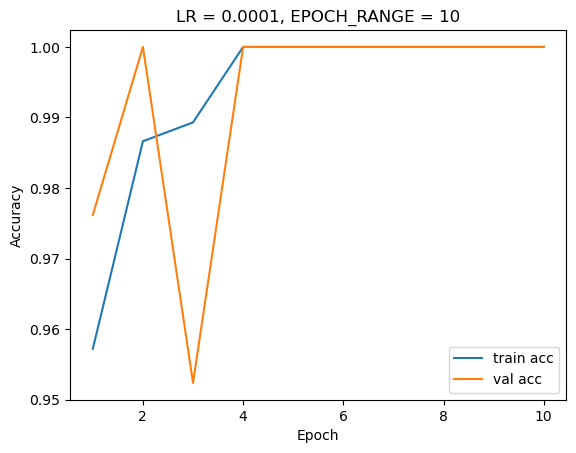

[[67  0  0  0]
 [ 0 76  0  0]
 [ 0  0 17  0]
 [ 0  0  0 48]]


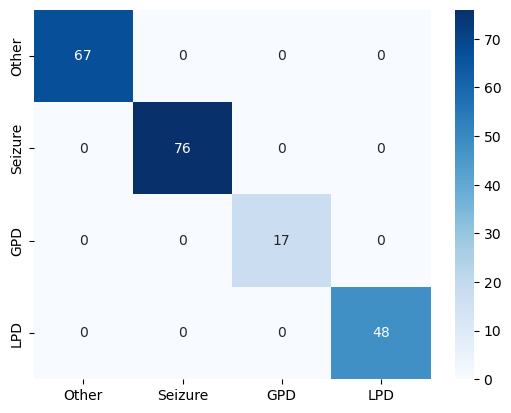



########################################
### learning rate = 0.001, num epochs = 6
#########################
### Epoch 1
Epoch 1 Loss = 0.6011, train accuracy = 0.5376, validation accuracy = 0.7143
#########################
### Epoch 2
Epoch 2 Loss = 0.2755, train accuracy = 0.6358, validation accuracy = 0.5857
#########################
### Epoch 3
Epoch 3 Loss = 0.1786, train accuracy = 0.7493, validation accuracy = 0.7391
#########################
### Epoch 4
Epoch 4 Loss = 0.1473, train accuracy = 0.7839, validation accuracy = 0.6812
#########################
### Epoch 5
Epoch 5 Loss = 0.102, train accuracy = 0.8444, validation accuracy = 0.913
#########################
### Epoch 6
Epoch 6 Loss = 0.2333, train accuracy = 0.7378, validation accuracy = 0.6232


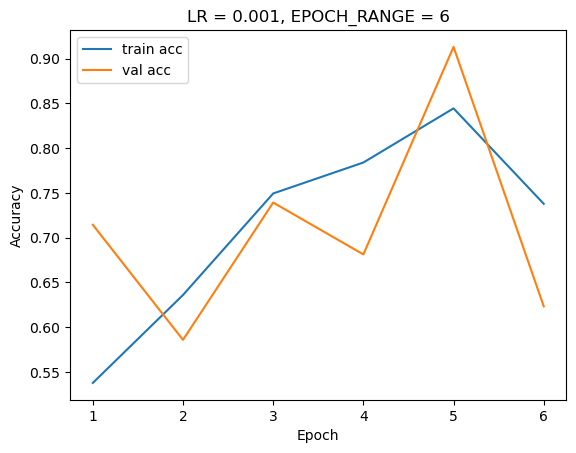

[[40 10  1 16]
 [ 3 74  0  1]
 [ 6  0 14  1]
 [16  0  0 26]]


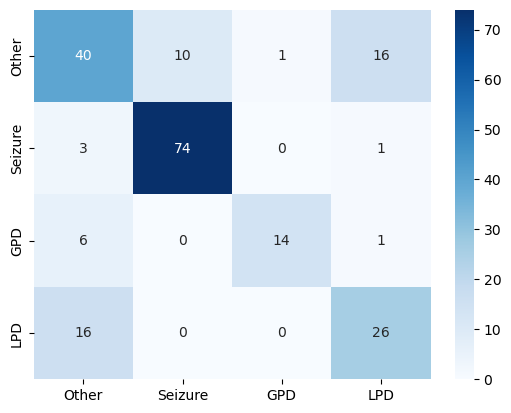



########################################
### learning rate = 0.001, num epochs = 10
#########################
### Epoch 1
Epoch 1 Loss = 0.5561, train accuracy = 0.7112, validation accuracy = 0.6905
#########################
### Epoch 2
Epoch 2 Loss = 0.1556, train accuracy = 0.8262, validation accuracy = 0.6667
#########################
### Epoch 3
Epoch 3 Loss = 0.1282, train accuracy = 0.8262, validation accuracy = 0.9524
#########################
### Epoch 4
Epoch 4 Loss = 0.2113, train accuracy = 0.8449, validation accuracy = 0.4762
#########################
### Epoch 5
Epoch 5 Loss = 0.2172, train accuracy = 0.6283, validation accuracy = 0.6667
#########################
### Epoch 6
Epoch 6 Loss = 0.1534, train accuracy = 0.7807, validation accuracy = 0.7857
#########################
### Epoch 7
Epoch 7 Loss = 0.1032, train accuracy = 0.8587, validation accuracy = 0.9024
#########################
### Epoch 8
Epoch 8 Loss = 0.0644, train accuracy = 0.9093, validation accuracy = 0

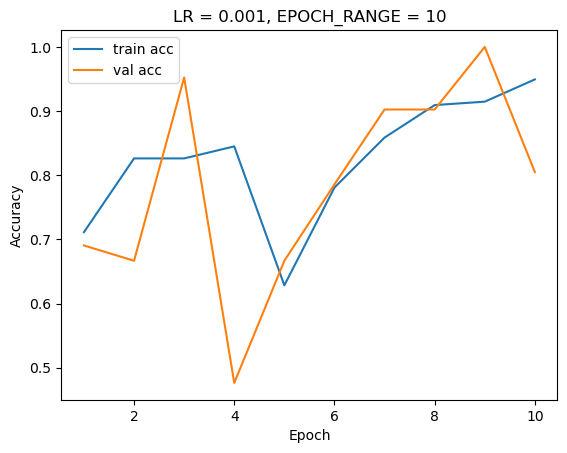

[[53  2  3  9]
 [ 4 71  0  0]
 [ 1  0 16  1]
 [ 5  0  1 42]]


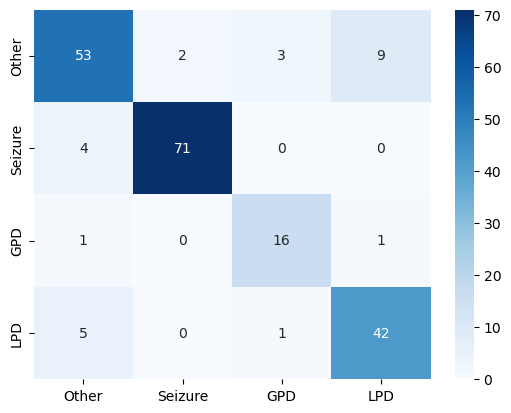

In [133]:
LRs = [0.0001, 0.001]
EPOCH_RANGEs = [6, 10]

for lr in LRs:
    for EPOCH_RANGE in EPOCH_RANGEs:
        train_accuracies, val_accuracies, val_true, val_preds = train_CNN_specs(lr, EPOCH_RANGE)
        plt.plot(range(1, EPOCH_RANGE+1), train_accuracies, label='train acc')
        plt.plot(range(1, EPOCH_RANGE+1), val_accuracies, label='val acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f'LR = {lr}, EPOCH_RANGE = {EPOCH_RANGE}')
        plt.legend()
        plt.show()

        #take latter half of epochs
        val_true = np.array(val_true[len(val_true)//2:])
        val_preds = np.array(val_preds[len(val_preds)//2:])
        val_conf_matrix = confusion_matrix(val_true, val_preds)
        class_names = ['Other','Seizure','GPD','LPD']
        print(val_conf_matrix)
        sns.heatmap(val_conf_matrix, annot=True, cmap='Blues', fmt='d',xticklabels=class_names, yticklabels=class_names)
        plt.show()

The best model was with `lr = 0.0001` and `EPOCH_RANGE = 10`